In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import datetime
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPool2D
from tensorflow.keras.layers import Reshape, BatchNormalization, Dropout, Flatten, Permute
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, ELU
from tensorflow.keras.metrics import binary_accuracy, categorical_accuracy
from tensorflow.train import AdamOptimizer

tf.enable_eager_execution()

In [3]:
! unzip ./gdrive/My\ Drive/data.zip

Archive:  ./gdrive/My Drive/data.zip
  inflating: X_train_valid.npy       
   creating: __MACOSX/
  inflating: __MACOSX/._X_train_valid.npy  
  inflating: person_train_valid.npy  
  inflating: __MACOSX/._person_train_valid.npy  
  inflating: y_train_valid.npy       
  inflating: __MACOSX/._y_train_valid.npy  
  inflating: y_test.npy              
  inflating: __MACOSX/._y_test.npy   
  inflating: X_test.npy              
  inflating: __MACOSX/._X_test.npy   
  inflating: person_test.npy         
  inflating: __MACOSX/._person_test.npy  


In [0]:
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

person_train_valid = np.load("person_train_valid.npy")
person_test = np.load("person_test.npy")


In [0]:
X_train_valid = X_train_valid[:, :-3, :]
X_test = X_test[:, :-3, :]

X_train_valid = np.expand_dims(X_train_valid, 3)
X_test = np.expand_dims(X_test, 3)

person_train_valid = np.squeeze(person_train_valid)
person_test = np.squeeze(person_test)

y_train_valid -= 769
y_test -= 769


In [0]:
def preprocess(X):
    
    shape = X.shape
    n = shape[0]
    X = X.reshape((n, -1))
    
    min_ = np.min(X, 1).reshape(n, 1)
    max_ = np.max(X, 1).reshape(n, 1)
    delta = (max_ - min_) / 2
    
    X = (X - min_ - delta) / delta
    X = X.reshape(shape)
    return tf.cast(X, tf.float32)
    

In [0]:
X_train_valid = preprocess(X_train_valid)
X_test = preprocess(X_test)

In [75]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))

print ('Test data shape: {}'.format(X_test.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115,)
Test data shape: (443, 22, 1000, 1)
Test target shape: (443,)
Person test shape: (443,)


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid, y_train_valid))
train_dataset = train_dataset.shuffle(2115).batch(256)

In [0]:
class DCGAN():
    
    def __init__(self, image_shape, z_dim=100, subject=False):
        
        self.image_shape = image_shape
        self.z_dim = z_dim
        self.n_classes = 9 if subject else 4
        
        self._encoder = self._make_encoder()
        self._discriminator = self._make_discriminator()
        self._generator = self._make_generator()
        self._classifier = self._make_classifier()
        self._clf_variables = [var for var in self._classifier.variables if var not in self._encoder.variables]
        
        self._opt_D = AdamOptimizer(1e-4)
        self._opt_G = AdamOptimizer(1e-4)
        self._opt_clf = AdamOptimizer(1e-4)
    
        self.history={}
        self.history['loss_G'] = []
        self.history['loss_D_real'] = []
        self.history['loss_D_fake'] = []
        self.history['loss_D'] = []
        self.history['loss_clf'] = []
        
        self.history['acc_real'] = []
        self.history['acc_fake'] = []
        self.history['acc_clf'] = []
        self._encoder.summary()
        #self._discriminator.summary()
        #print('-'*80)
        #self._generator.summary()
    
    def _make_encoder(self):
        
        model = Sequential()
        
        ## conv1
        #model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(self.image_shape)))
        #model.add(BatchNormalization())
        #model.add(LeakyReLU())
        #
        ## conv2
        #model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        #model.add(LeakyReLU())
        #
        ## conv3
        #model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        #model.add(LeakyReLU())
        
        n_filters = [64, 64, 128, 256, 512]
        r = 0.25
        
        # conv1
        model.add(Conv2D(n_filters[0], (1,10), (1,2), 'valid', input_shape=self.image_shape))
        model.add(ReLU())
        model.add(Conv2D(n_filters[1], (22, 1), (1,1), 'valid'))
        model.add(ELU())
        model.add(MaxPool2D((1,3), (1,3)))
        model.add(Dropout(r))
        model.add(Permute((3,2,1)))

        # conv2
        model.add(Conv2D(n_filters[2], (n_filters[1], 10), (1,1), 'valid'))
        model.add(Permute((3,2,1)))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(MaxPool2D((1,3), (1,3)))
        model.add(Dropout(r))

        # conv3
        model.add(Conv2D(n_filters[3], (n_filters[2], 10), (1,1), 'valid'))
        model.add(Permute((3,2,1)))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(MaxPool2D((1,3), (1,3)))
        model.add(Dropout(r))

        # conv4
        model.add(Conv2D(n_filters[4], (n_filters[3], 10), (1,1), 'valid'))
        model.add(Permute((3,2,1)))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(MaxPool2D((1,3), (1,3), 'same'))
        model.add(Dropout(r))

        # output
        model.add(Flatten())
    
        return model
    
    def _make_discriminator(self):
        
        input = Input(self.image_shape)
        h = self._encoder(input)
        output = Dense(1)(h)
        
        return Model(input, output)
    
    
    def _make_generator(self):
        
        model = Sequential()
        
        model.add(Dense(11*8*256, input_shape=(self.z_dim,)))
        model.add(Reshape((11, 8, 256)))
        
        # transpose conv1
        model.add(Conv2DTranspose(128, (3, 5), strides=(2, 5), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        
        # transpose conv2
        model.add(Conv2DTranspose(64, (3, 5), strides=(1, 5), padding='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        
        # transpose conv3
        model.add(Conv2DTranspose(1, (3, 5), strides=(1, 5), padding='same'))
        
        model.add(Activation('tanh'))
        
        return model
    
    def _make_classifier(self):
        
        input = Input(self.image_shape)
        h = self._encoder(input)
        h = Dense(256)(h)
        h = BatchNormalization()(h)
        h = ReLU()(h)
        output = Dense(self.n_classes)(h)
        
        return Model(input, output)
    
    def _discriminator_loss(self, logit_real, logit_fake):
        
        label_real = tf.ones_like(logit_real)
        label_fake = tf.zeros_like(logit_fake)
        
        loss_real = tf.losses.sigmoid_cross_entropy(label_real, logit_real)
        loss_fake = tf.losses.sigmoid_cross_entropy(label_fake, logit_fake)
        
        return loss_real, loss_fake
    
    def _generator_loss(self, logit_fake):
        
        label_fake = tf.ones_like(logit_fake)
        loss_fake = tf.losses.sigmoid_cross_entropy(label_fake, logit_fake)
        
        return loss_fake
    
    def _classifier_loss(self, label, logit):

        label = tf.cast(label, tf.int32)
        
        return tf.losses.sparse_softmax_cross_entropy(label, logit)
        
    
    def _discriminator_acc(self, logit_real, logit_fake):
        
        logit_real_ = tf.squeeze(logit_real)
        logit_fake_ = tf.squeeze(logit_fake)
        
        label_real = tf.ones_like(logit_real_)
        label_fake = tf.zeros_like(logit_fake_)
    
        acc_real = binary_accuracy(label_real, tf.nn.sigmoid(logit_real_))
        acc_fake = binary_accuracy(label_fake, tf.nn.sigmoid(logit_fake_))
    
        return acc_real, acc_fake
    
    def _classifier_acc(self, label, logit):
        label = tf.cast(label, tf.int32)
        y_true = tf.one_hot(label, self.n_classes)
        y_pred = tf.nn.softmax(logit)
        
        return tf.reduce_mean(categorical_accuracy(y_true, y_pred))
    
    
    def data_generator(self, X, batch_size):
        
        idx = np.random.choice(X.shape[0], batch_size, replace=False)
    
        yield X[idx]
    
    def train(self, dataset, test, epoches_gan, epoches_clf, batch_size, verbose=False, plot=False):
        
        print('Training discriminator and generator......')
        for epoch in range(epoches_gan):
            
            start = time.time()
            cnter = 0
            #for images_real in self.data_generator(X, batch_size):
            for images_real, label in dataset:
                
                noise = tf.random_normal([batch_size, self.z_dim])
      
                with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
            
                    # generate fake images
                    images_fake = self._generator(noise, training=True)
       
                    # compute logits
                    logit_real = self._discriminator(images_real, training=True)
                    logit_fake = self._discriminator(images_fake, training=True)
    
                    # compute generator and discriminator loss
                    loss_G = self._generator_loss(logit_fake)
                    loss_D_real, loss_D_fake = self._discriminator_loss(logit_real, logit_fake)
                    loss_D = 0.5 * (loss_D_real + loss_D_fake) 
                
                    # compute discriminator acc
                    acc_real, acc_fake = self._discriminator_acc(logit_real, logit_fake)
                    
                    self.history['loss_G'].append(loss_G)
                    self.history['loss_D_real'].append(loss_D_real)
                    self.history['loss_D_fake'].append(loss_D_fake)
                    self.history['loss_D'].append(loss_D)
                    self.history['acc_real'].append(acc_real)
                    self.history['acc_fake'].append(acc_fake)
                    
                grad_G = G_tape.gradient(loss_G, self._generator.variables)
                grad_D = D_tape.gradient(loss_D, self._discriminator.variables)
               
                if cnter % 4 == 0:
                    self._opt_G.apply_gradients(zip(grad_G, self._generator.variables))
                self._opt_D.apply_gradients(zip(grad_D, self._discriminator.variables))
                
                cnter += 1
            
            # print
            print('-' * 80)
            print(f'epoch: {epoch+1}')
            print(f"time used: {time.time() - start:.3f}")
            if verbose:
                print(f"loss_G: {self.history['loss_G'][-1]}")
                #print(f"loss_D_real: {self.history['loss_D_real'][-1]}")
                #print(f"loss_D_fake: {self.history['loss_D_fake'][-1]}")
                print(f"loss_D: {self.history['loss_D'][-1]}")
                print(f"acc_real: {self.history['acc_real'][-1]}")
                print(f"acc_fake: {self.history['acc_fake'][-1]}")
            
            
            
        print('Trainging classifer......')
        X, y = test
        for epoch in range(epoches_clf):
            
            start = time.time()
            loss_l = []
            acc_l = []
            for images_real, label in dataset:
                
                with tf.GradientTape() as clf_tape:
                    # compute classifer loss
                    logit = self._classifier(images_real)
                    loss_clf = self._classifier_loss(label, logit)
                    
                    # compute classifer acc
                    acc_clf = self._classifier_acc(label, logit)
                   
                    loss_l.append(loss_clf)
                    acc_l.append(acc_clf)
                  
                grad_clf = clf_tape.gradient(loss_clf, self._clf_variables)
                self._opt_clf.apply_gradients(zip(grad_clf, self._clf_variables))
        
            test_acc = np.mean(np.argmax(self._classifier.predict(X), 1) == y)
           
            self.history['loss_clf'].append(np.mean(loss_l))
            self.history['acc_clf'].append(test_acc)
        
            # print
            print('-' * 80)
            print(f'epoch: {epoch+1}')
            print(f"time used: {time.time() - start:.3f}, test acc: {test_acc}")
            
        y_pred = np.argmax(self._classifier.predict(X), 1)
        print("#"*80)
        print(f"F1 scores: {f1_score(y, y_pred, average=None)}")
            
        if plot:
            
            fig = plt.figure(figsize=(18,12))
    
            ax1 = fig.add_subplot(2,2,1)
            ax1.plot(self.history['loss_G'], label='loss_G')
            ax1.plot(self.history['loss_D_real'], '-', label='loss_D_real')
            ax1.plot(self.history['loss_D_fake'], '-', label='loss_D_fake')
            ax1.plot(self.history['loss_D'], label='loss_D')
            ax1.set_ylabel('loss')
            ax1.set_xlabel('iterations')
            ax1.legend()

            ax2 = fig.add_subplot(2,2,2)
            ax2.plot(self.history['acc_real'], label='acc_real')
            ax2.plot(self.history['acc_fake'], label='acc_fake')
            ax2.set_ylabel('acc')
            ax2.set_xlabel('iterations')
            ax2.legend()
            
            ax3 = fig.add_subplot(2,2,3)
            ax3.plot(self.history['loss_clf'])
            ax3.set_ylabel('loss')
            ax3.set_xlabel('epoches')
            ax3.set_title('classification_loss')
            
            
            acc = self.history['acc_clf']
            ws = 10
            #smoothed = [np.mean(acc[i:i+ws]) for i in range(len(acc)-ws)]
            
            
            ax4 = fig.add_subplot(2,2,4)
            ax4.plot(self.history['acc_clf'])
            #ax4.plot(smoothed, color='c', label='smoothed')
            ax4.set_ylabel('acc')
            ax4.set_xlabel('epoches')
            ax4.set_title('classification_test_acc')
            #ax4.legend()
            print('-'*80)
            print(f"classifier max accuracy: {max(acc)}")
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 22, 496, 64)       704       
_________________________________________________________________
re_lu_13 (ReLU)              (None, 22, 496, 64)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 1, 496, 64)        90176     
_________________________________________________________________
elu_52 (ELU)                 (None, 1, 496, 64)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 1, 165, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 1, 165, 64)        0         
_________________________________________________________________
permute_52 (Permute)         (None, 64, 165, 1)        0         
__________

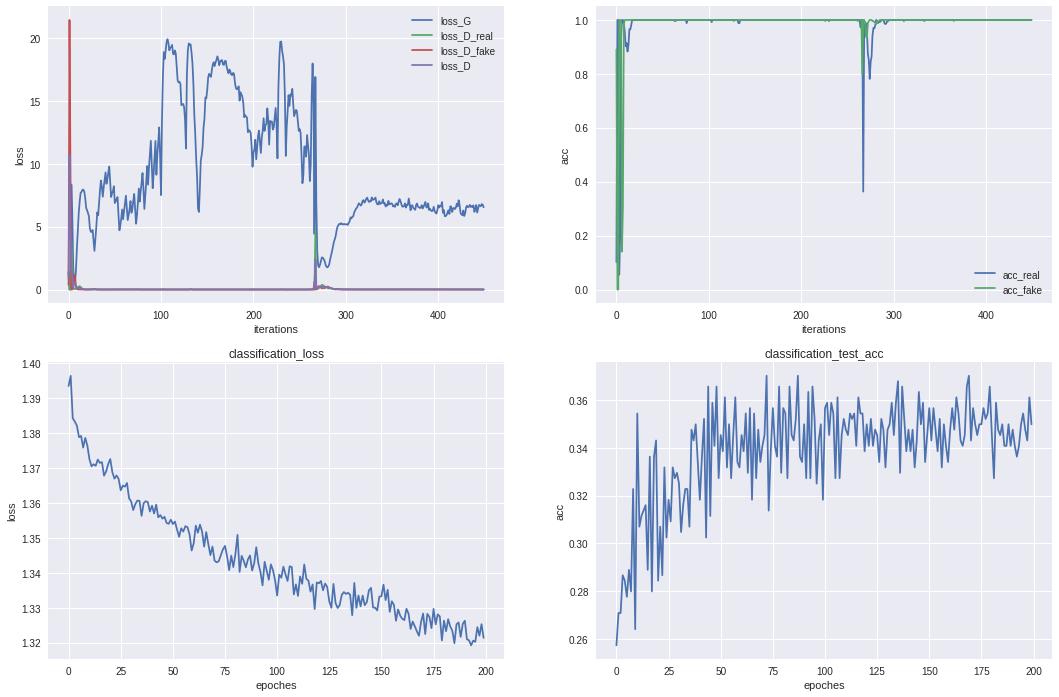

In [78]:
X_test_np = np.array(X_test)
test_dataset_np = (X_test_np, y_test)

epoches_gan = 50
epoches_clf = 200
input_shape = X_train_valid[0].shape
batch_size = 256
z_dim = 100

model_sig = DCGAN(input_shape, z_dim)
model_sig.train(train_dataset, test_dataset_np, epoches_gan, epoches_clf, batch_size, verbose=False, plot=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 22, 496, 64)       704       
_________________________________________________________________
re_lu_15 (ReLU)              (None, 22, 496, 64)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 1, 496, 64)        90176     
_________________________________________________________________
elu_56 (ELU)                 (None, 1, 496, 64)        0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 1, 165, 64)        0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 1, 165, 64)        0         
_________________________________________________________________
permute_56 (Permute)         (None, 64, 165, 1)        0         
__________

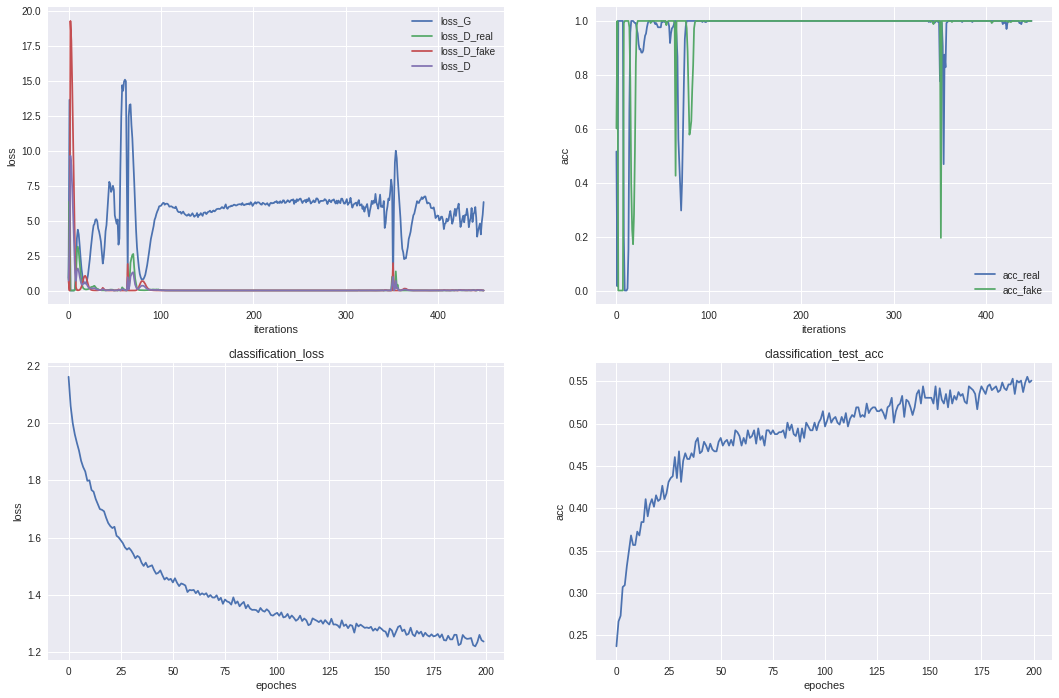

In [79]:
# change dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_valid, person_train_valid))
train_dataset = train_dataset.shuffle(2115).batch(256)
test_dataset_np_sub = (X_test_np, person_test)

epoches_gan = 50
epoches_clf = 200
input_shape = X_train_valid[0].shape
batch_size = 256
z_dim = 100

model_subject = DCGAN(input_shape, z_dim, subject=True)
model_subject.train(train_dataset, test_dataset_np_sub, epoches_gan, epoches_clf, batch_size, verbose=False, plot=True)

In [0]:
def accuracy_over_time(model, X_test, y_test, period=100):
    
    X = X_test.copy()
    
    n = 1000 // period
    acc = [0]*n
    
    for i in range(n):
        if i != 0:
            X[:,:,-period*i:] = 0
            
        acc[i] = np.sum(np.argmax(model.predict(X), axis=1) == y_test) / len(y_test)
  
    acc = acc[::-1]
    max_acc = max(acc)
    max_acc_idx = acc.index(max_acc)
    best_seq_len = max_acc_idx*period
    print(f'max acc: {max_acc:.3f} with sequence length: {best_seq_len}')
    
    
    x = list(range(0, 1000, period))
  
    plt.plot(x, acc)
    plt.axvline(best_seq_len, color='c', linestyle='--')
    plt.axhline(max_acc, color='c', linestyle='--')
    plt.xlabel('sequence length')
    plt.ylabel('acc')

max acc: 0.352 with sequence length: 920


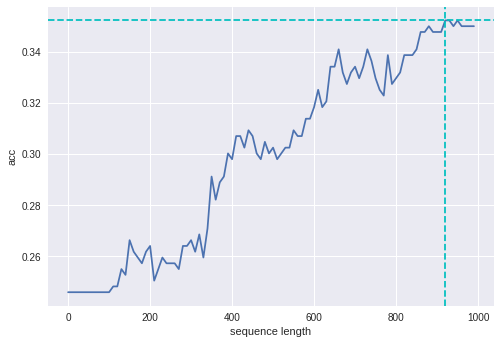

In [81]:
accuracy_over_time(model_sig._classifier, X_test_np, y_test, 10)

max acc: 0.555 with sequence length: 890


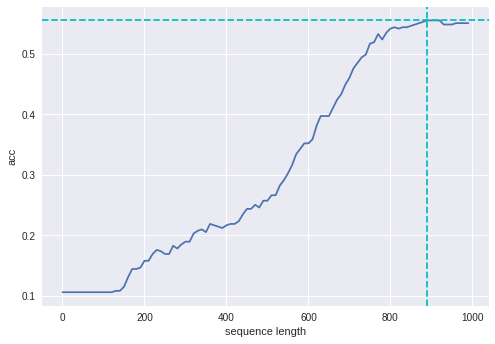

In [82]:
accuracy_over_time(model_subject._classifier, X_test_np, person_test, 10)